## <span style="color:green">**Version en cours**</span>

# Segmentez des clients d'un site e-commerce
## Notebook 3 : Tests de modèles de clustering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* Feature ingineering (cf Notebook 2)
* **Tests de modèles de clustering** : c'est l'objet de ce notebook  
* Simulation d'un contrat de maintenace (Notebbok 4)  

**Tests de modèles de clustering**  
* Objectif :
   * bla bla bla 

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

**Premier test de clustering via scikit-learn KMeans**  
* Premier test avec 5 clusters
* Détermination du nombre optimal de clusters
* Test avec 7 clusters

**Second test KMeans - Feature `Montant` passée au log**  
* KMeans - 7 clusters  
* KMeans - 4, 5, 6 ou 8 clusters  

**Troisième test KMeans - Feature `Montant` normalisée via QuantileTransformer**  
* Détermination du nombre optimal de clusters
* Entraînement du modèle - 4 clusters
* Entraînement du modèle - 5 clusters

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('yellowbrick')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.
yellowbrick est déjà installé.


* Import des modules

In [4]:
%matplotlib inline

In [5]:
# Import des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [6]:
mpl.rcParams["figure.figsize"] = (9,6)

## 1.3 Fonctions

In [7]:
def plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=None):
    """Affiche le graphique KElbowVisualizer d'un modèle KMeans permettant la recherche du nombre optimal de clusters
    Elbow Method (metric='distorion') ou Calinski-Harabasz (metric='Calinski-Harabasz')
    Arguments :
        random_state (int) : seed
        k (tuple)          : (min, max+1)
        metric (str)       : 'distortion' par défaut (somme des distances au carré de chaque point à son centre de cluster)
        X (DataFrame)      : dataset d'input
    """
    
    # Instanciation du modèle et du visualiseur
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(
        kmeans,
        k=k,
        metric=metric
    )
    
    # Alimentation du visualiseur
    visualizer.fit(X)
    
    # Visualisation
    visualizer.finalize()

    return

In [51]:
def display_silhouette_scores(X, random_state=0, k_values=range(3, 11)):
    """Affiche les scores de silhouette d'un modèle KMeans pour la recherche du nombre optimal de clusters
    Renvoit le nombre de clusters ayant obtenu le meilleur score
    Arguments :
        X (DataFrame)      : dataset d'input
        random_state (int) : seed
        k (range)          : plage de k à tester
    Retour :
        silhouette_k (int) : nombre de clusters du meilleur score
    """
    silhouette_scores = []
    silhouette_best_score, silhouette_k = -1, -1
    
    # Calcul des scores de silhouette pour chaque valeur de k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X)
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        if silhouette_avg > silhouette_best_score:
            silhouette_best_score = silhouette_avg
            silhouette_k = k
            
    # Affichage du tableau des scores
    df_silhouette_scores = pd.DataFrame({'k': k_values, 'Score de Silhouette': silhouette_scores}).set_index('k')
    display(df_silhouette_scores.sort_values('Score de Silhouette', ascending=False))
    
    return silhouette_k

In [15]:
def plot_silhouettevisualizer(X, k):
    """Affiche le graphique SilhouetteVisualizer d'un modèle KMeans
    Arguments :
    X (DataFrame) : données
    k (int)       : nombre de clusters
    """
    # Instanciation du modèle KMeans
    model = KMeans(k)
    # Instanciation du visualiseur
    visualizer = SilhouetteVisualizer(model)
    # Alimentation du visualiseur
    visualizer.fit(X)
    # Visualisation du graphique
    visualizer.finalize() 

## 1.4 Chargement des données

In [8]:
# Chargement 'df_features'
df_features = pd.read_csv('df_features.csv')

In [9]:
# Affichage des premières et dernières lignes
df_features

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717
...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089


# 2 Premier test de clustering via scikit-learn KMeans

## 2.0 Premier test avec 5 clusters

In [10]:
# Nombre de clusters
k = 5

In [11]:
# Initialisation du modèle
kmeans = KMeans(n_clusters=k, random_state=0)

In [12]:
# Sélection des features
X = df_features[['Récence', 'Fréquence', 'Montant']]

In [13]:
# Entraînement du modèle
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

In [14]:
# Ajout des labels de cluster à 'df_features'
df_features['Cluster'] = kmeans.labels_

In [15]:
# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,3
...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,2


,Cluster,Id client,%
0,0,30627,32.20
1,1,2900,3.05
2,2,29719,31.24
3,3,18451,19.40
4,4,13424,14.11


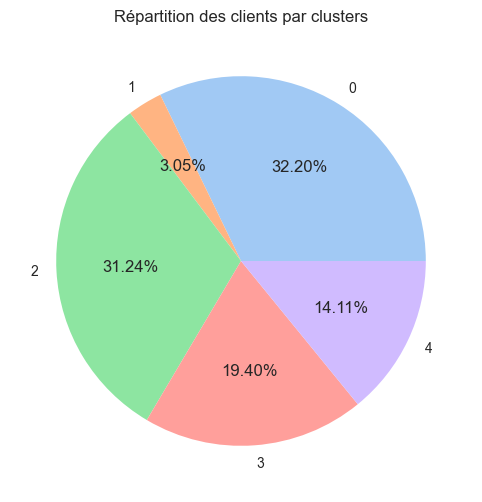

In [16]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* Le modèle segmente bien les clients en **5 clusters** 
* Chaque segment représente **entre 3 et 32 % des clients**

## 2.1 Détermination du nombre optimal de clusters

### 2.1.1 Méthode du Coude (Elbow Method)

* Cette méthode consiste à tracer le pourcentage de variance expliquée en fonction du nombre de clusters.  
* Le point où l'ajout de clusters supplémentaires ne donne pas de meilleure explication des données permet de déterminer le nombre optimal de clusters. Ce point ressemble souvent à un "coude" sur le graphique.  
* La bibliothèque `yellowbrick` propose des outils de visualisation pour la méthode du coude

* Graphique KElbowVisualizer pour un nombre de clusters **k** compris entre 3 et 10

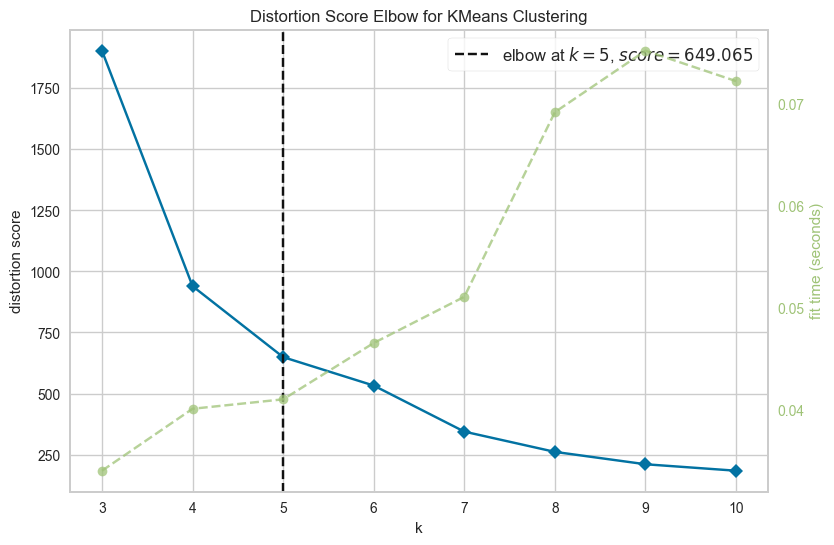

In [17]:
# Graphique KElbowVisualizer Elbow Method, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

* **Avant k=5** : chaque augmentation de k entraîne une amélioration significative de la performance du clustering (mesurée par une forte diminution de la distorsion), la pente de la courbe bleue est importante  
* **Après k=5** : la courbe commence à s'aplatir, les bénéfices de l'ajout de clusters supplémentaires diminuent, l'ajout de clusters supplémentaires n'apporte pas d'amélioration proportionnelle de la performance
* **k=5** : c'est le nombre de clusters optimal selon cette méthode
* Le score de **649.065** représente la valeur de distorsion (somme des distances au carré de chaque point à son centre de cluster) pour **k=5**

* Le coude n'est pas franchement marqué, d'autres méthodes pourront confirmer ou infirmer le choix de 5 clusters
* Remarque : la pente de la courbe redevient un peu plus forte entre 6 et 7 clusters, choisir 7 clusters serait-il pertinent ?

### 2.1.2 Methode du Score de Silhouette

* Le score de silhouette calcule la distance entre les clusters ainsi que la cohésion au sein des clusters :  
   * Soit $a$ la distance moyenne d'un point avec les autres points du même cluster  
   * Soit $b$ la distance moyenne d'un point aves les clusters les plus proches  
   * La différence $a-b$, si elle est positive, indique que le point est bien positionné dans son cluster  
   * Si elle est négative, le point est situé dans un cluster voisin  
   * Plus cette différence est proche de 0, plus le point se situe à la limite de 2 clusters
   * Le ratio $\frac{a-b}{max(a, b)}$ est le coefficient de silhouette du point
   * La moyenne de tous les coefficients de silhouettes est le score de sihhouette, indiquant la qualité de la segmentation
* Un score plus élevé indique une meilleure définition des clusters
* La bibliothèque `yellowbrick` propose des outils de visualisation pour cette méthode

#### 2.1.2.1 Calcul des scores de silhouette

* Comme pour la méthode du coude, recherche du meilleur score de silhouette pour **k** compris entre 1 et 10

In [19]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.597566
4,0.575646
7,0.547662
5,0.543333
8,0.542496
6,0.539311
9,0.537341
10,0.522042


* Le meilleur score de silhouette (**0.598**) est obtenu lorsque KMeans segmente les clients en **3** clusters
* Cette segmentation semble peu pertinente du point de vue métier, Olist attend un plus grand nombre de groupes de clients

#### 2.1.2.2 Visualisation

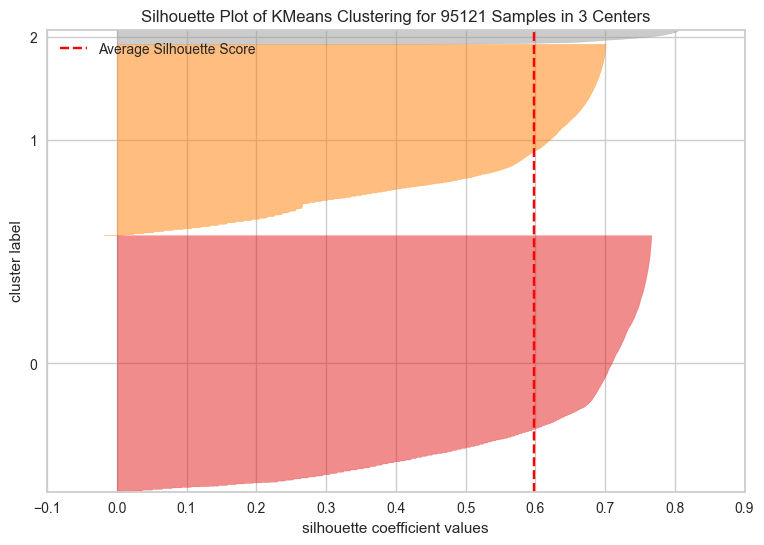

In [20]:
# Affichage SilhouetteVisualizer
plot_silhouettevisualizer(X, silhouette_k)

* Le nombre de clients n'est pas uniformément réparti, le cluster 2 (gris) contient beucoup moins de points
* La moyenne des coefficients de silhouette est très proche de **0.6**, la qualité de clustering semble relativement bonne  
* Aucun coefficient n'est négatif, signe qu'aucun client n'a été mal positionné  

### 2.1.3 Méthode Calinski-Harabasz (score du rapport variance)

* Mesure à quel point les points sont proches les uns des autres au sein de chaque cluster
* Évalue à quel point les clusters sont éloignés les uns des autres
* Un score élevé indique un clustering mieux défini  

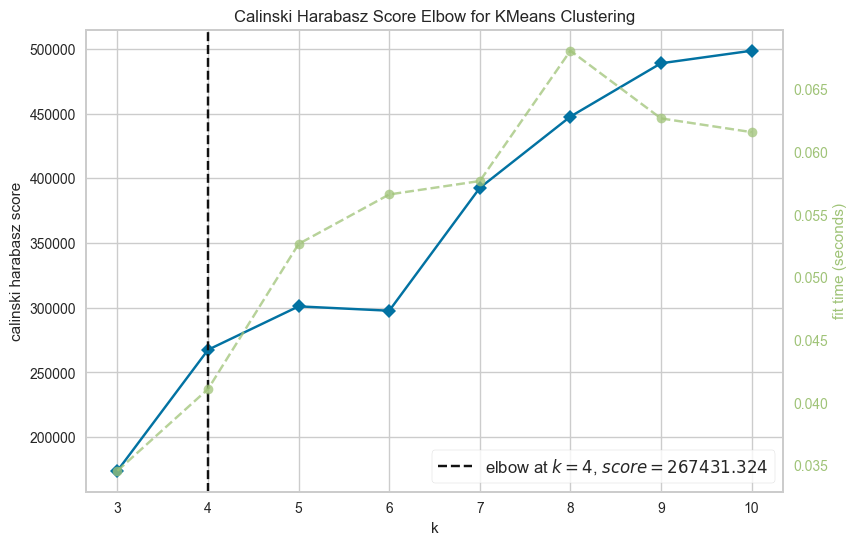

In [21]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* Avec une pente qui augmente moins fortement entre 5 et 6 clusters, la méthode Calinski Harabasz préconise une **segmentation en 4 clusters** 
* Les scores obtenus avec une segmentation en 7, 8 ou 9 clusters semblent aussi intéressants puisque leurs scores augmentent de manière significative
* Le passage de 9 à 10 clusters ne semble pas apporter d'amélioration proportionnellement parlant

### 2.1.4 Nombre de clusters retenus

* Les différentes méthodes testées donnent des résultats différents :
| Méthode              | Nombre de clusters (k) | 
|----------------------|------------------------|  
| Elbow Method         | **5**                  |  
| Score de Silhouette  | **3**                  |  
| Calinski Harabasz    | **4**                  |
* Les courbes des graphiques Elbow Method et Calinski Harabasz laissent présumer qu'une segmentation en **7** clusters pourrait étre intéressante

* Visualisation de la méthode des scores de silhouette avec **k=7**

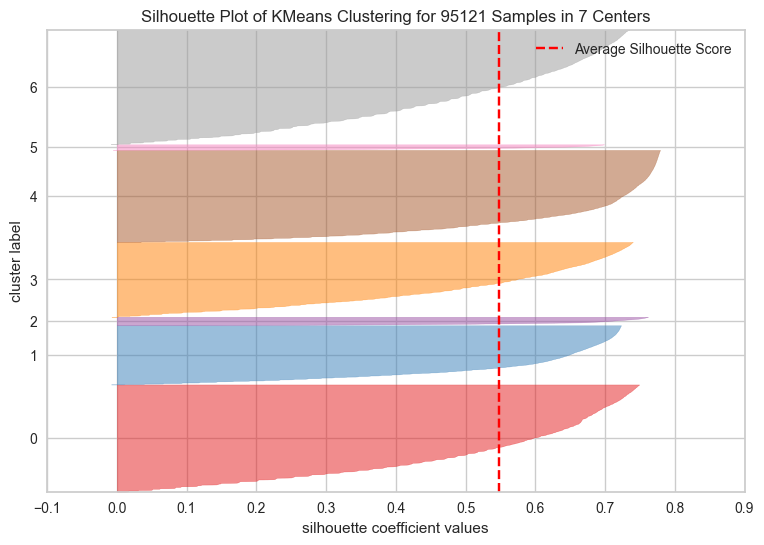

In [22]:
# Affichage SilhouetteVisualizer
plot_silhouettevisualizer(X, 7)

* La moyenne des coefficients de silhouette est d'environ **0.55**
* Les clusters 2 et 6 sont largement moins peuplés
* Les coefficients sont positifs : il n'y a pas de chevauchement entre les clusters  

## 2.2 Test KMeans avec 7 clusters

### 2.2.1 Entrainement du modèle

In [23]:
# Nombre de clusters
k = 7

# Initialisation du modèle
kmeans = KMeans(n_clusters=k, random_state=0)

# Sélection des features
X = df_features[['Récence', 'Fréquence', 'Montant']]

# Entraînement du modèle
kmeans.fit(X)

KMeans(n_clusters=7, random_state=0)

### 2.2.2 Affichage des résultats

In [24]:
# Attribution des labels de cluster au DataFrame
df_features['Cluster'] = kmeans.labels_

# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,0
...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,2


### 2.2.3 Analyse des clusters

#### 2.2.3.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,21979,23.11
1,1,1747,1.84
2,2,24005,25.24
3,3,14857,15.62
4,4,11919,12.53
5,5,1153,1.21
6,6,19461,20.46


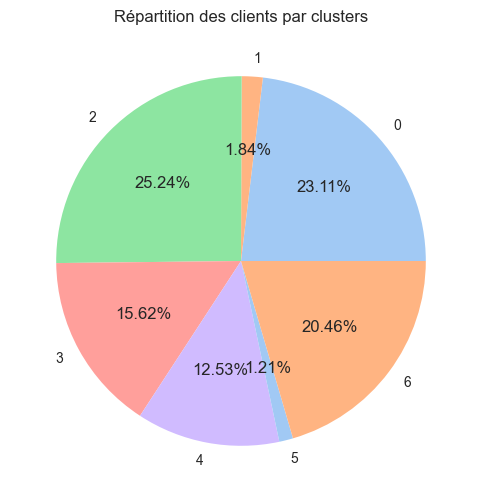

In [25]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition est relativement homogène, à l'exception des clusters 1 et 5 beaucoup moins peuplés (le Silhouette plot montrait aussi 2 clusters de très faible taille)
* Sous réserve qu'il y ait un sens métier, cette répartition n'est pas génante

#### 2.2.3.2 Distributions des features par cluster

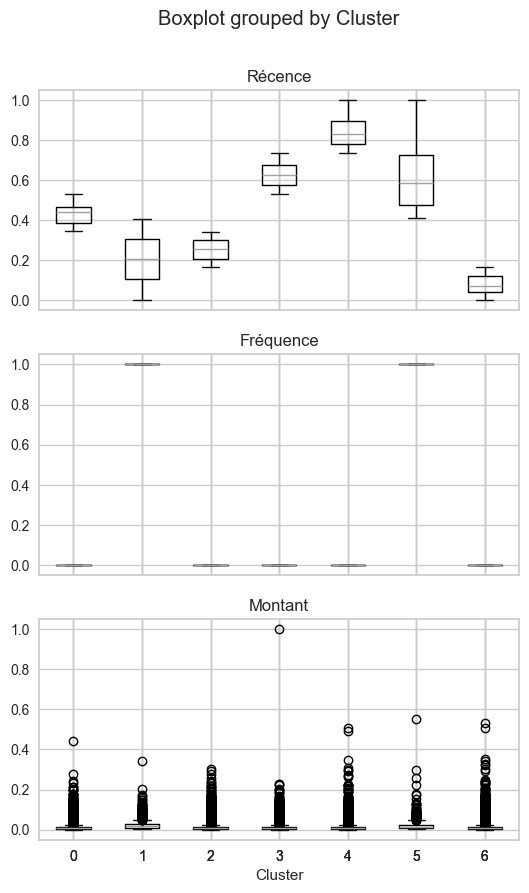

In [26]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Les clusters 1 et 5 se distinguent facilement par une `Fréquence` à 1 (clients ayant passé plus d'une commande) avec une `Récence` plus faible pour le cluster 1 que pour le 5, sans chevauchement
* Si on fait abstraction des boxplots `Récence` des clusters 1 et 5, il n'y a pas chevauchement, le clustering se fait bien au niveau de cette feature
* La feature `Montant` n'est pas interprétable en l'état, les boxplots se chevauchent et montrent de nombreuses valeurs aberrantes. Il est particulièrement difficile d'analyser la segmentation par montants.

### 2.2.4 Conclusions du test

#### 2.2.4.1 Constat

* KMeans ne peut segmenter correctement le dataset compte-tenu de la feature `Montant`
* Les boxplots de cette variable pour chaque cluster montrent des distributions fortement asymétriques, avec de nombreux outliers
* Le boxplot de la variable d'origine montre une distribution similaire :

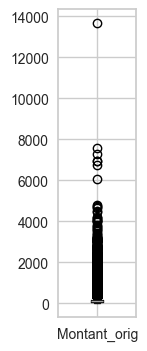

In [27]:
# Distribution `Montant_orig`
boxplot = df_features.boxplot(column='Montant_orig', grid=True, figsize=(1, 4))

#### 2.2.4.2 Pistes

Il semble pertinent de transformer la variable `Montant` de manière à ce que sa distribution soit exploitable par le modèle.
* Utiliser une technique de mise à l'échelle robuste aux outliers (RobustScaler) ?
* Passer la variable au log ?
* Utiliser le coefficient de variation (Montant / moyenne des montants) ?

* Ces pistes sont explorées dans le **"Notebook 2 - Feature ingineering"**, partie **"5 Feature ingineering variable `Montant`"**

# 3 Second test KMeans - Feature `Montant` passée au log

* Suite à la problématique de la forte asymétrie de la feature `Montant`, cette variable a été passée au log, et un nouveau jeu de données a été généré

In [28]:
# Chargement du nouveau dataset
df_features = pd.read_csv('df_features_2.csv')
df_features['Montant'] = df_features['Montant_log']

## 3.1 Détermination du nombre optimal de clusters

### 3.1.1 Elbow Method

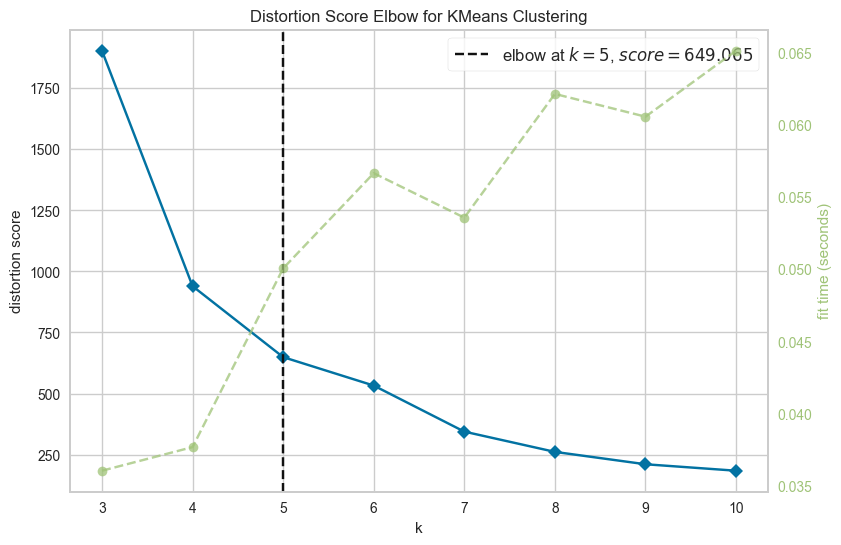

In [29]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

* Le résultat est identique a celui obtenu avant passage au log

### 3.1.2 Scores de Silhouette

In [31]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.597566
4,0.575646
7,0.547662
5,0.543333
8,0.542496
6,0.539311
9,0.537341
10,0.522042


* Le résultat est aussi strictement identique à celui obtenu avant transformation logarithmique : le meilleur score de silhouette (**0.598**) est obtenu lorsque KMeans segmente les clients en **3** clusters

### 3.1.3 Calinski-Harabasz

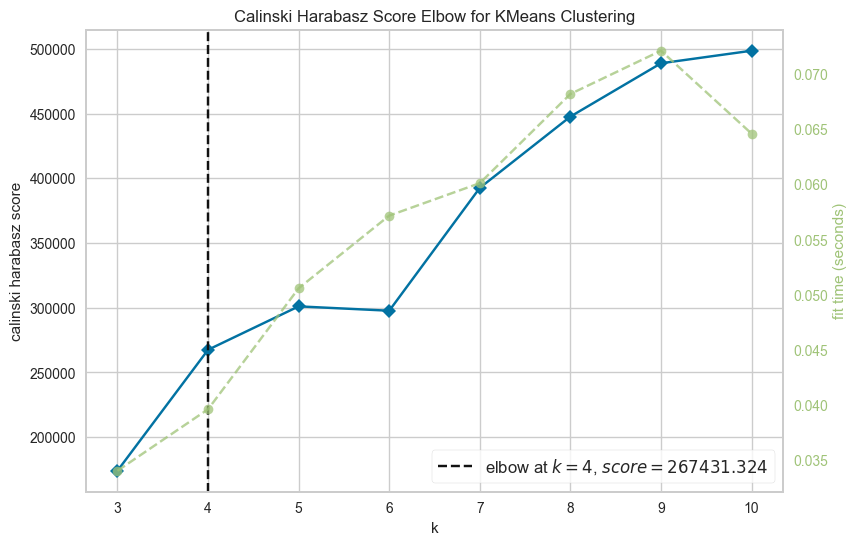

In [32]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* Sans surprise maintenant, la méthode de Calinski Harabasz préconise une segmentation en **4** clusters

## 3.2 KMeans - 7 clusters

* Les différentes méthodes testées donnent des résultats différents :
| Méthode              | Nombre de clusters (k) | 
|----------------------|------------------------|  
| Elbow Method         | **5**                  |  
| Score de Silhouette  | **3**                  |  
| Calinski Harabasz    | **4**                  |
* Les courbes des graphiques Elbow Method et Calinski Harabasz laissent présumer qu'une segmentation en **7 clusters** pourrait étre intéressante

### 3.2.1 Entrainement du modèle

In [33]:
# Nombre de clusters
k = 7

# Initialisation du modèle
kmeans = KMeans(n_clusters=k, random_state=0)

# Sélection des features
X = df_features[['Récence', 'Fréquence', 'Montant']]

# Entraînement du modèle
kmeans.fit(X)

KMeans(n_clusters=7, random_state=0)

### 2.2.2 Affichage des résultats

In [34]:
# Attribution des labels de cluster au DataFrame
df_features['Cluster'] = kmeans.labels_

# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Montant_log,Montant_qt,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.363304,0.363304,0.636131,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.136688,0.136688,0.021178,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.294376,0.294376,0.398488,5
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.200801,0.200801,0.118413,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.408757,0.408757,0.777711,6
...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.736404,0.736404,0.993256,6
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.291726,0.291726,0.388941,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.331096,0.331096,0.518331,5
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.355043,0.355043,0.605161,4


### 3.2.3 Analyse des clusters

#### 3.2.3.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,20440,21.49
1,1,2900,3.05
2,2,18470,19.42
3,3,13540,14.23
4,4,14880,15.64
5,5,12169,12.79
6,6,12722,13.37


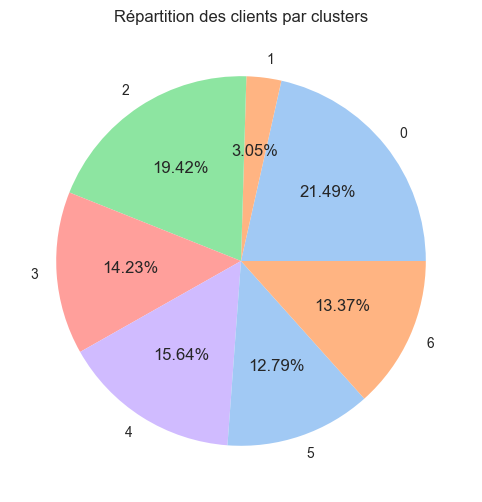

In [35]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition semble plus homogène après trnasformation logarithmique de la variable `Montant`, avec maintenant 1 seul cluster moins peuplé  

#### 3.2.3.2 Distributions des features par cluster

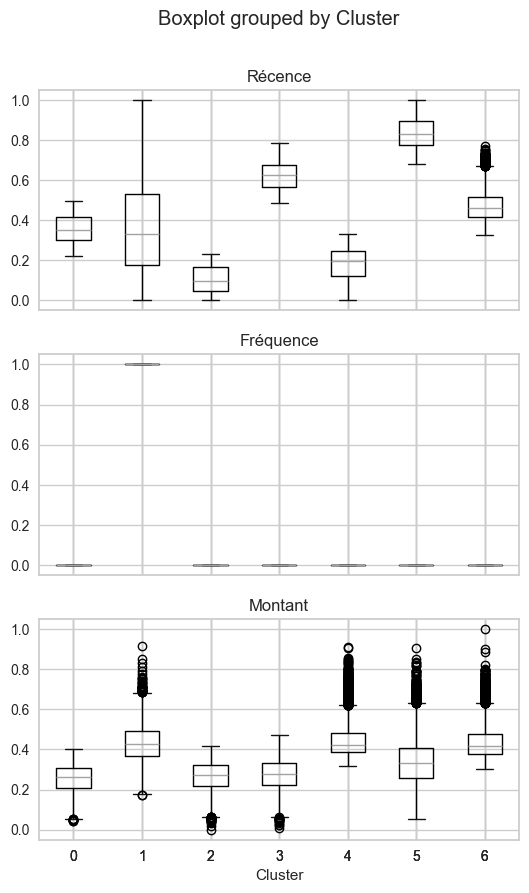

In [36]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Hormis pour la feature `Fréquence`, les boxplots se chevauchent, indiquant des clients à cheval entre plusieurs cluster
* C'est particulièrement le cas au niveau de la feature `Montant`

* La transformation logarithmique de la feature `Montant` n'est pas concluante.

## 3.3 KMeans avec 4, 5, 6 ou 8 clusters

* Tests de répartition des montants entre les clusters, pour 4, 5, 6 ou 8 clusters

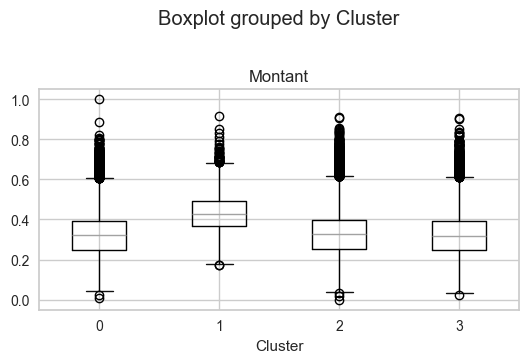

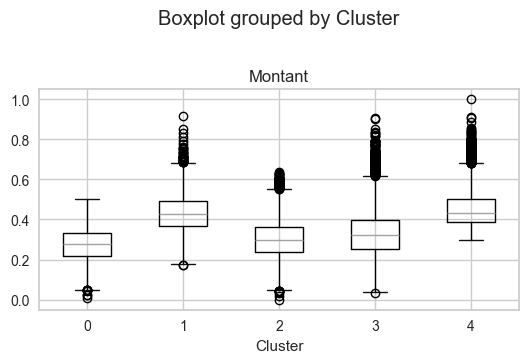

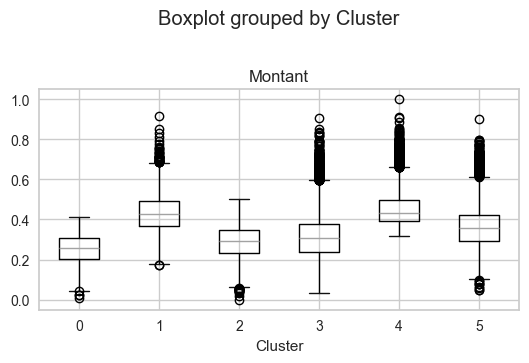

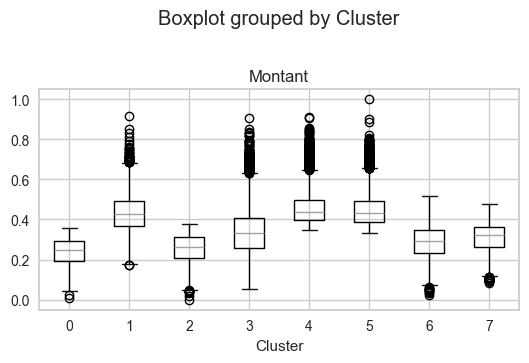

In [37]:
X = df_features[['Récence', 'Fréquence', 'Montant']]

for k in (4, 5, 6, 8):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    df_features['Cluster'] = kmeans.labels_
    boxplots = df_features.boxplot(column='Montant', by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Le nombre de clusters semble ne pas avoir d'influence, les chevauchements persistent
* Ces tests confirment les mauvais résultats obtenus après transformation logarithmique de la varianle `Montant`

# 4 Troisième test KMeans - Feature `Montant` normalisée via QuantileTransformer

In [38]:
# Chargement du nouveau dataset
df_features = pd.read_csv('df_features_2.csv')
df_features['Montant'] = df_features['Montant_qt']

## 4.1 Détermination du nombre optimal de clusters

### 4.1.1 Elbow Method

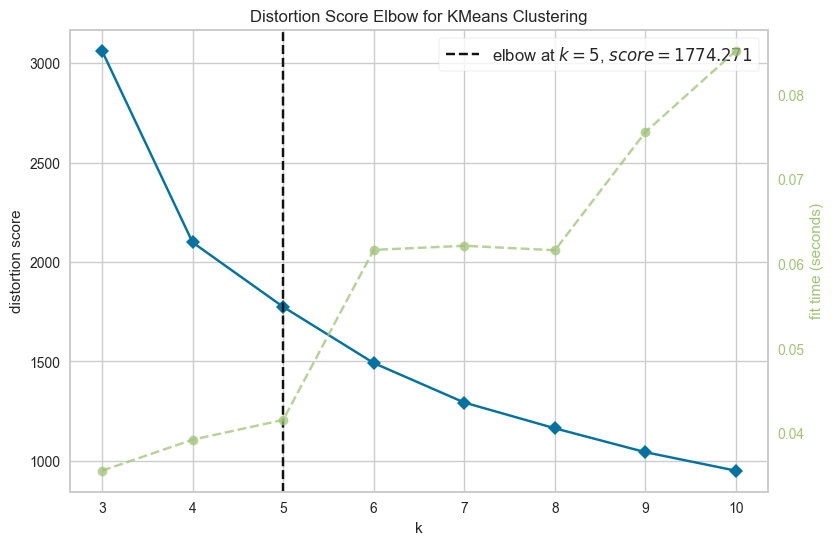

In [39]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

### 4.1.2 Scores de Silhouette

In [41]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.492181
4,0.414738
5,0.379735
6,0.351411
7,0.346011
10,0.342225
9,0.340674
8,0.335504


* La méthode des scores de Silhouette indique un nombre optimal de clusters de **3**

### 4.1.3 Calinski-Harabasz

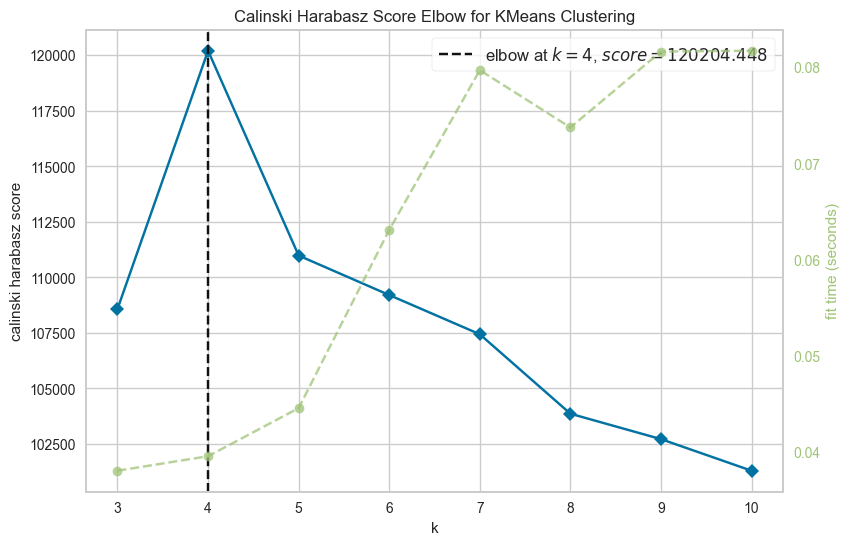

In [42]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* La méthode de Calinski Harabasz indique un nombre optimal de **4 clusters** de manière très nette

* Une segmentation en 3 clusters n'apporterait pas suffisament de précision aux équipes Marketing d'Olist
* Les prochains tests se feront avec 4 et 5 clusters

## 4.2 Entrainement du modèle - 4 clusters

In [43]:
# Nombre de clusters
k = 4


# Initialisation du modèle
kmeans = KMeans(n_clusters=k, random_state=0)

# Sélection des features
X = df_features[['Récence', 'Fréquence', 'Montant']]

# Entraînement du modèle
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

### 4.2.1 Affichage des résultats

In [44]:
# Attribution des labels de cluster au DataFrame
df_features['Cluster'] = kmeans.labels_

# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Montant_log,Montant_qt,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.636131,0.363304,0.636131,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.021178,0.136688,0.021178,0
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.398488,0.294376,0.398488,3
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.118413,0.200801,0.118413,0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.777711,0.408757,0.777711,1
...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.993256,0.736404,0.993256,1
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.388941,0.291726,0.388941,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.518331,0.331096,0.518331,3
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.605161,0.355043,0.605161,1


### 4.2.2 Analyse des clusters

#### 4.2.2.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,33234,34.94
1,1,34586,36.36
2,2,2900,3.05
3,3,24401,25.65


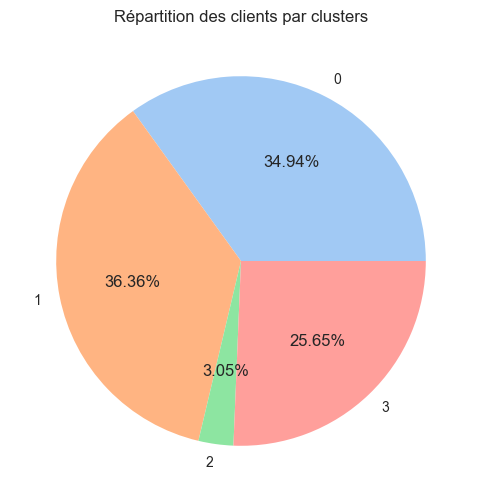

In [45]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition est relativement homogène, avec 1 cluster moins peuplé  

#### 4.2.2.2 Distributions des features par cluster

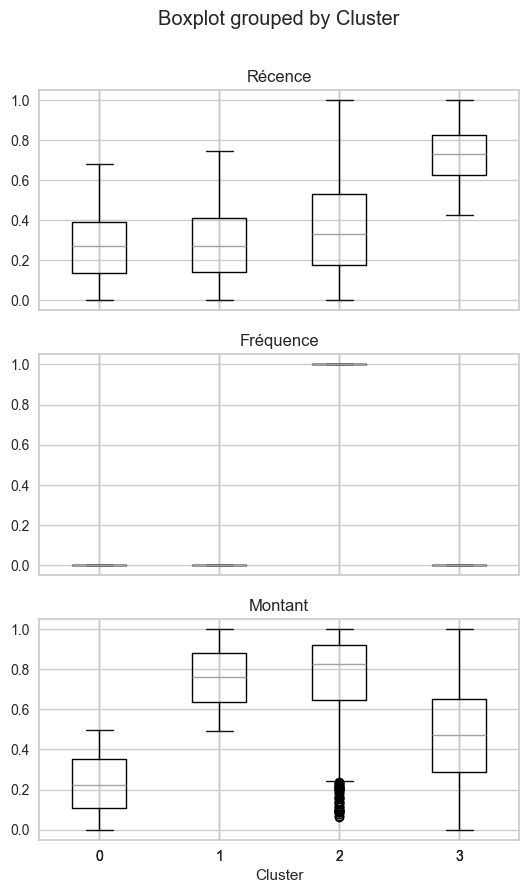

In [46]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Les chevauchements sont importants, ce clustering est loin d'être optimal

## 4.3 Entrainement du modèle - 5 clusters

In [47]:
# Nombre de clusters
k = 5

# Initialisation du modèle
kmeans = KMeans(n_clusters=k, random_state=0)

# Sélection des features
X = df_features[['Récence', 'Fréquence', 'Montant']]

# Entraînement du modèle
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

### 4.3.1 Affichage des résultats

In [48]:
# Attribution des labels de cluster au DataFrame
df_features['Cluster'] = kmeans.labels_

# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Montant_log,Montant_qt,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.636131,0.363304,0.636131,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.021178,0.136688,0.021178,4
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.398488,0.294376,0.398488,0
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.118413,0.200801,0.118413,0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.777711,0.408757,0.777711,3
...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.993256,0.736404,0.993256,3
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.388941,0.291726,0.388941,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.518331,0.331096,0.518331,3
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.605161,0.355043,0.605161,1


### 4.3.2 Analyse des clusters

#### 4.3.2.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,20255,21.29
1,1,26711,28.08
2,2,2900,3.05
3,3,19073,20.05
4,4,26182,27.52


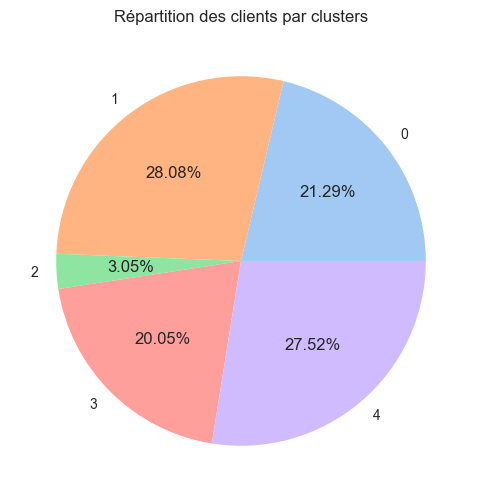

In [49]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition est relativement homogène, avec maintenant 1 cluster moins peuplé  

#### 4.3.2.2 Distributions des features par cluster

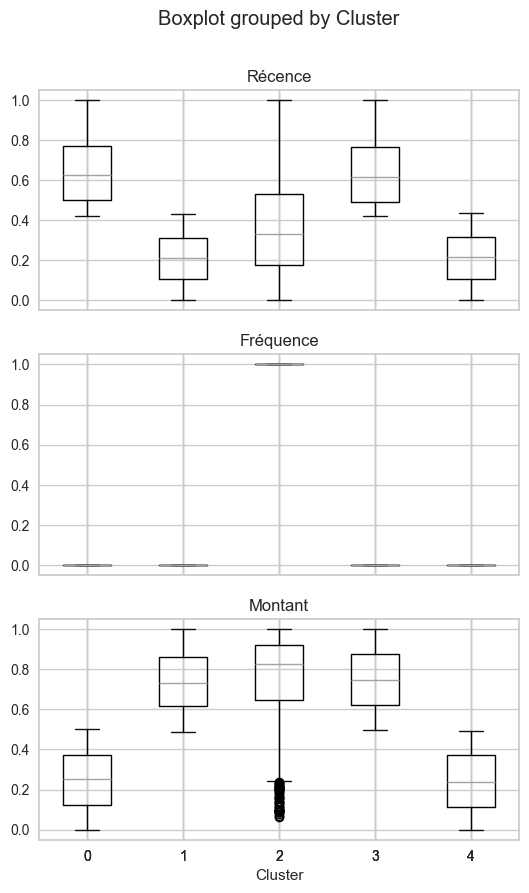

In [50]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Le cluster 1 regroupe les clients ayant une `Fréquence` à 1 (clients ayant passé plus d'une commande)  
* Si on fait abstraction des boxplots `Récence` du cluster 2, il n'y a que de très légers chevauchements entre les boxplots, le clustering semble se faire correctement  
* La segmentation par le feature `Montant` est beaucoup plus claire dans cette normalisée par les quantiles